# Einasto Profile

In this notebook we visually test the Einasto profile (and do some timing etc.)

In [1]:
%pylab inline
from halomod import HaloModel
from scipy.interpolate import InterpolatedUnivariateSpline as spline

Populating the interactive namespace from numpy and matplotlib


In [2]:
hm = HaloModel(profile_model="Einasto")

## Density Profile

First, to check for blatant errors, we run with full vectors for both $r$ and $m$:

In [6]:
_ = hm.profile.rho(hm.r,hm.m)

Now plot versus $r$:

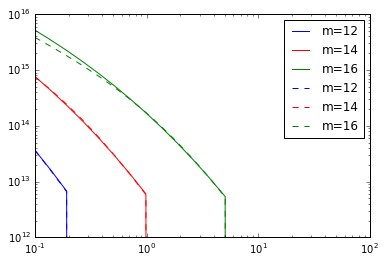

In [14]:
hm.update(profile_model="Einasto")
plot(hm.r, hm.profile.rho(hm.r,1e12),label="m=12",color="b")
plot(hm.r, hm.profile.rho(hm.r,1e14),label="m=14",color="r")
plot(hm.r, hm.profile.rho(hm.r,1e16),label="m=16",color="g")

hm.update(profile_model="NFW")
plot(hm.r, hm.profile.rho(hm.r,1e12),label="m=12",ls="--",color="b")
plot(hm.r, hm.profile.rho(hm.r,1e14),label="m=14",ls="--",color="r")
plot(hm.r, hm.profile.rho(hm.r,1e16),label="m=16",ls="--",color="g")

legend(loc=0)
xscale('log')
yscale('log')
show()

Now plot versus $m$:

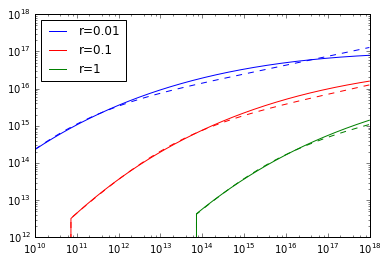

In [13]:
hm.update(profile_model="Einasto")
plot(hm.m, hm.profile.rho(0.01,hm.m),label="r=0.01",color="b")
plot(hm.m, hm.profile.rho(0.1,hm.m),label="r=0.1",color="r")
plot(hm.m, hm.profile.rho(1.0,hm.m),label="r=1",color="g")

hm.update(profile_model="NFW")
plot(hm.m, hm.profile.rho(0.01,hm.m),ls="--",color="b")
plot(hm.m, hm.profile.rho(0.1,hm.m),ls="--",color="r")
plot(hm.m, hm.profile.rho(1.0,hm.m),ls="--",color="g")

legend(loc=0)
xscale('log')
yscale('log')
show()

## Fourier Transform

First plot against $k$:

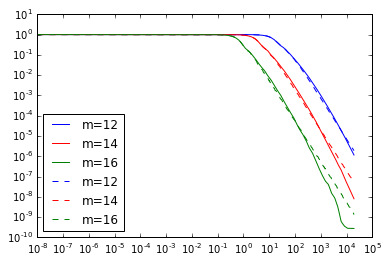

In [5]:
hm.update(profile_model="Einasto")
#plot(hm.k, hm.profile.u(hm.k,1e12),label="m=12",color="b")
#print hm.profile.u(hm.k,1e12)
#plot(hm.k, hm.profile.u(hm.k,1e14),label="m=14",color="r")
#plot(hm.k, hm.profile.u(hm.k,1e16),label="m=16",color="g")

plot(hm.k, hm.profile.u(hm.k,1e12),label="m=12",color="b")
#print hm.profile.u(hm.k,1e12)
plot(hm.k, hm.profile.u(hm.k,1e14),label="m=14",color="r")
plot(hm.k, hm.profile.u(hm.k,1e16),label="m=16",color="g")


hm.update(profile_model="NFW")
plot(hm.k, hm.profile.u(hm.k,1e12),label="m=12",ls="--",color="b")
plot(hm.k, hm.profile.u(hm.k,1e14),label="m=14",ls="--",color="r")
plot(hm.k, hm.profile.u(hm.k,1e16),label="m=16",ls="--",color="g")

hm.update(profile_model="Einasto")
legend(loc=0)
xscale('log')
yscale('log')
show()

Now plot against $m$:

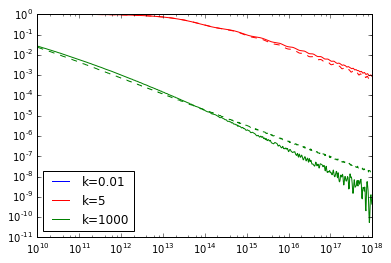

In [5]:
hm.update(profile_model="Einasto")
plot(hm.m, hm.profile.u(0.01,hm.m),label="k=0.01",color="b")
plot(hm.m, hm.profile.u(5,hm.m),label="k=5",color="r")
plot(hm.m, hm.profile.u(1000,hm.m),label="k=1000",color="g")

hm.update(profile_model="NFW")
plot(hm.m, hm.profile.u(0.01,hm.m),ls="--",color="b")
plot(hm.m, hm.profile.u(5,hm.m),ls="--",color="r")
plot(hm.m, hm.profile.u(1000,hm.m),ls="--",color="g")

legend(loc=0)
xscale('log')
yscale('log')
show()

We may have to be a bit wary of the high-mass, high-k tail, but other than that we should be okay. Finally, to make sure things run properly, try full matrix:

In [6]:
hm.update(profile_model="Einasto")
%timeit hm.profile.u(hm.k,hm.m)

hm.update(profile_model="NFW")
%timeit hm.profile.u(hm.k,hm.m)

1 loop, best of 3: 207 ms per loop
10 loops, best of 3: 73.5 ms per loop


Perhaps it's better to pre-cache results.

### Attempt to Cache Results

In [3]:
def f(x,a=0.18):
    return np.exp((-2/a)*(x**a-1))

In [4]:
def _p(K, c):
    minsteps = 1000

    res = np.zeros((len(K),len(c)))

    for ik, kappa in enumerate(K):
        smallest_period = np.pi / kappa
        dx = smallest_period / 8

        nsteps = max(int(np.ceil(c.max() / dx)),minsteps)

        x, dx = np.linspace(0, c.max(), nsteps, retstep=True)
        
        spl = spline(x, x*f(x)*np.sin(kappa*x)/kappa)
        intg = spl.antiderivative()
        res[ik,:] = intg(c) - intg(0)
    
    return np.clip(res,0,None)

In [139]:
K = np.logspace(-4,4,500)
c = np.logspace(0,2,1000)

pk = _p(K,c)

#plot(K,pk)
#xscale('log')
#yscale('log')

In [140]:
np.savez("uKc_einasto.npz",pk=pk,K=K,c=c)

In [146]:
from scipy.interpolate import RectBivariateSpline
def _newp(K,c):
    data = np.load("uKc_einasto.npz")
    pk = data['pk']
    _k = data['K']
    _c = data['c']
    
    c = np.atleast_1d(c)
    if np.isscalar(K):
        K = np.atleast_2d(K)
    if K.ndim < 2:
        if len(K)!=len(c):
            K = np.atleast_2d(K).T # should be len(rs) x len(k)
        else:
            K = np.atleast_2d(K)
    pk[pk<=0] = 1e-8
    
    spl = RectBivariateSpline(np.log(_k),np.log(_c),np.log(pk))
    cc = np.repeat(c,K.shape[0])
    return np.exp(hm.profile._reduce(spl.ev(np.log(K.flatten()),np.log(cc)).reshape(K.shape)))
    

In [144]:
c,K = hm.profile._get_k_variables(hm.k,hm.m)

In [147]:
%timeit _newp(K,c)

1 loop, best of 3: 199 ms per loop


(500,) (1000,) (500, 1000)
(500,) (1000,) (500, 1000)


/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


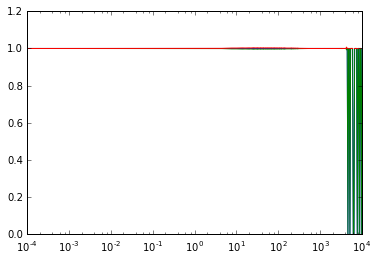

In [142]:
plot(np.logspace(-4,4,500),pk[:,0]/ _newp(np.logspace(-4,4,500),1))
plot(np.logspace(-4,4,500),_p(np.logspace(-4,4,500),np.atleast_1d(1)).flatten()/_newp(np.logspace(-4,4,500),1))
plot(np.logspace(-4,4,500),pk[:,0]/ _p(np.logspace(-4,4,500),np.atleast_1d(1)).flatten())

plot()
xscale('log')